In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.utils import to_categorical

In [2]:
# Load data
path = 'C:/Users/akshg/Desktop/Emotion CNN/'
data = pd.read_csv('icml_face_data.csv')

In [29]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
# Define emotions dictionary
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [4]:
# Function to prepare data
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
    return image_array, image_label

In [5]:
# Prepare data splits
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

In [6]:
# Preprocess data
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1)).astype('float32') / 255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1)).astype('float32') / 255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1)).astype('float32') / 255

train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [7]:
# Define class weights
class_weight = dict(zip(range(0, 7),
                        (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [8]:
# Define CNN model
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])


In [9]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [11]:
# Train the model
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight=class_weight,
                    epochs=12,
                    batch_size=32)

Epoch 1/12
898/898 [==============================] - 40s 43ms/step - loss: 0.2570 - accuracy: 0.3509 - val_loss: 1.5785 - val_accuracy: 0.4032
Epoch 2/12
898/898 [==============================] - 39s 44ms/step - loss: 0.2169 - accuracy: 0.4596 - val_loss: 1.3738 - val_accuracy: 0.4790
Epoch 3/12
898/898 [==============================] - 39s 44ms/step - loss: 0.1987 - accuracy: 0.5128 - val_loss: 1.3217 - val_accuracy: 0.5010
Epoch 4/12
898/898 [==============================] - 43s 48ms/step - loss: 0.1867 - accuracy: 0.5386 - val_loss: 1.3720 - val_accuracy: 0.4965
Epoch 5/12
898/898 [==============================] - 40s 45ms/step - loss: 0.1761 - accuracy: 0.5666 - val_loss: 1.2900 - val_accuracy: 0.5258
Epoch 6/12
898/898 [==============================] - 39s 43ms/step - loss: 0.1662 - accuracy: 0.5933 - val_loss: 1.2537 - val_accuracy: 0.5319
Epoch 7/12
898/898 [==============================] - 39s 43ms/step - loss: 0.1567 - accuracy: 0.6150 - val_loss: 1.2561 - val_accuracy:

In [12]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

113/113 [==============================] - 2s 14ms/step - loss: 1.4811 - accuracy: 0.5394
Test accuracy: 0.5394260287284851


In [13]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 1s 12ms/step


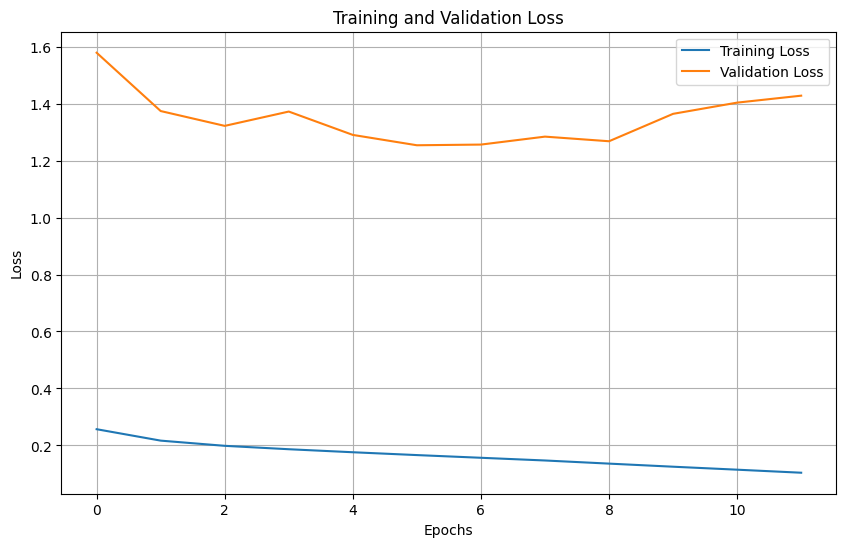

In [14]:
# Plot training/validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

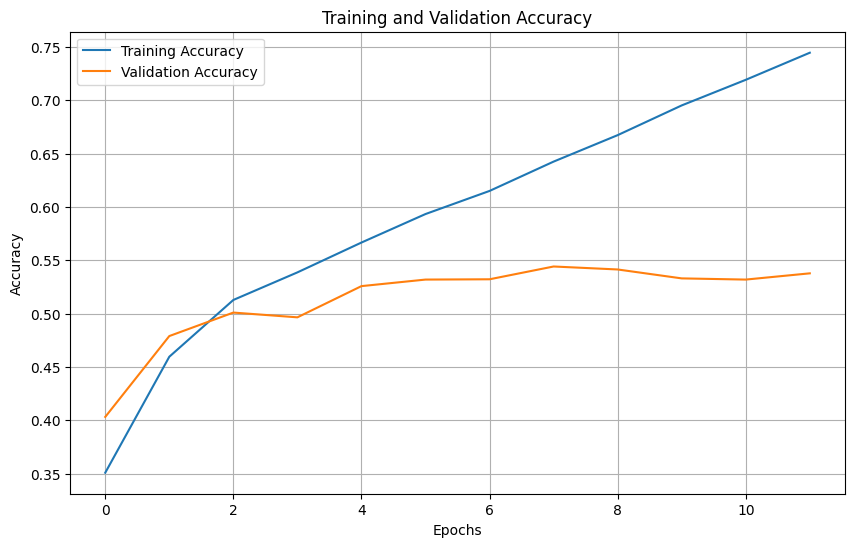

In [15]:
# Plot training/validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Function to plot examples of emotions
def plot_emotion_examples(label=0, num_examples=5):
    fig, axs = plt.subplots(1, num_examples, figsize=(20, 6))
    fig.suptitle('Examples of Emotion: ' + emotions[label], fontsize=16)
    for i in range(num_examples):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title('Example {}'.format(i+1))
        axs[i].axis('off')
    plt.show()


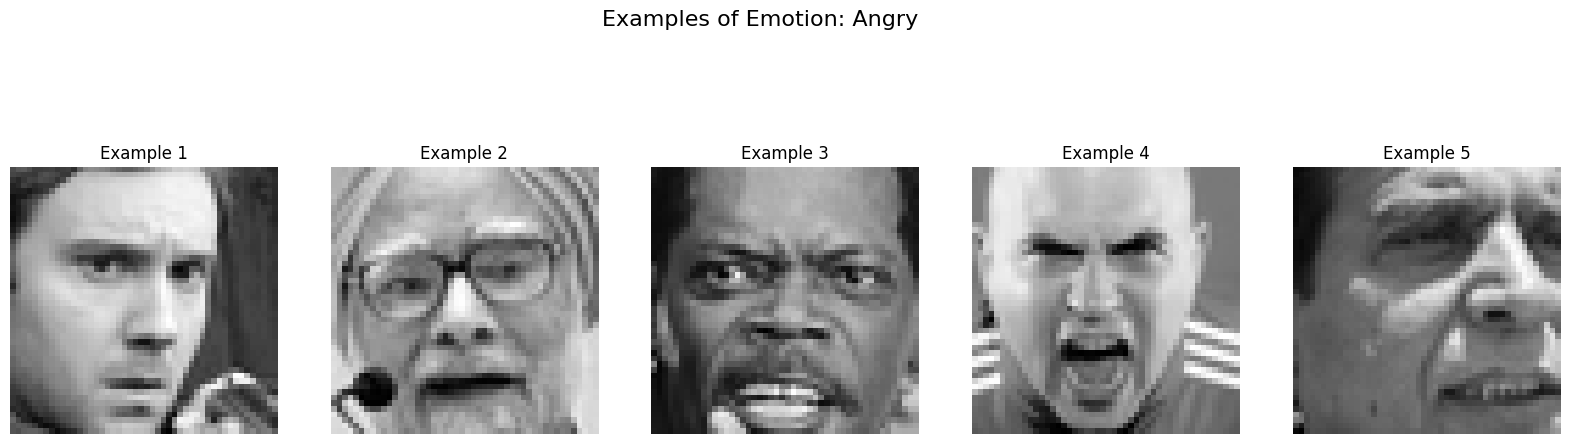

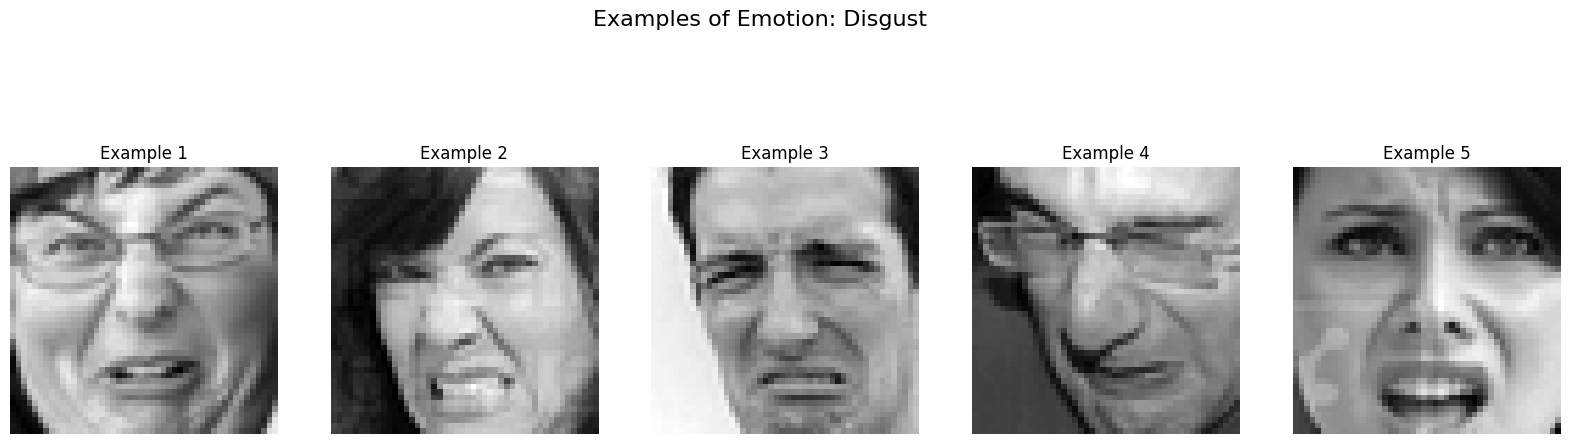

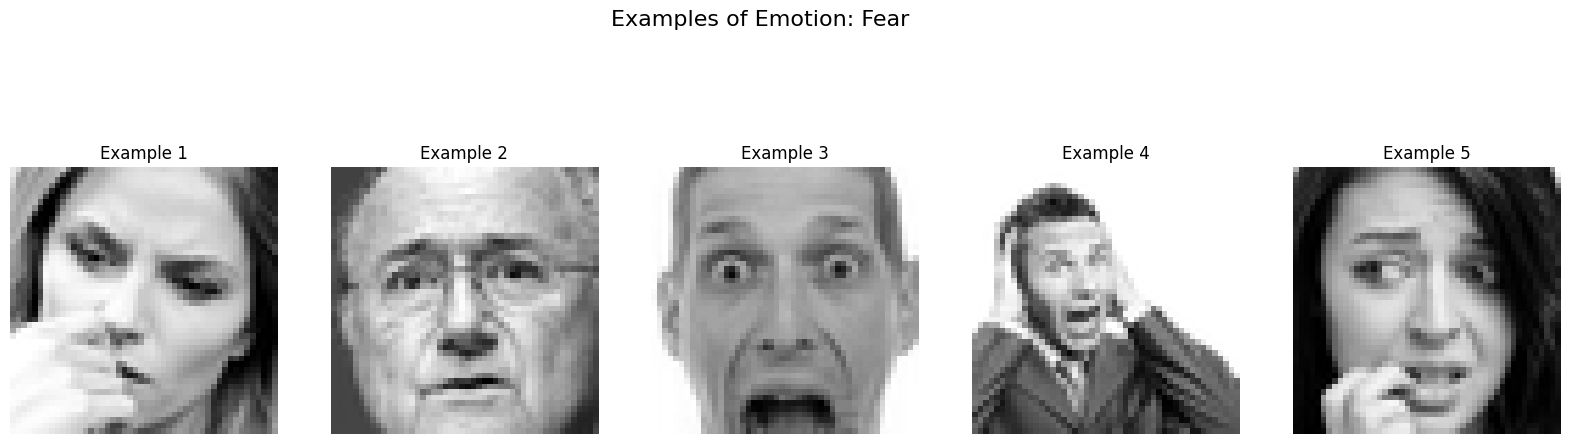

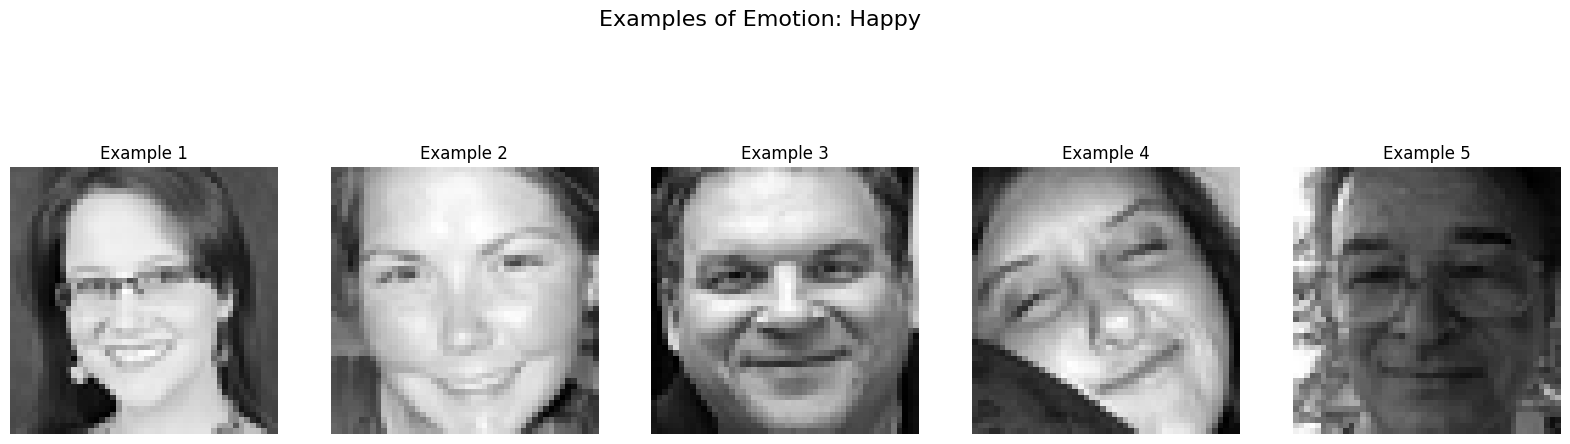

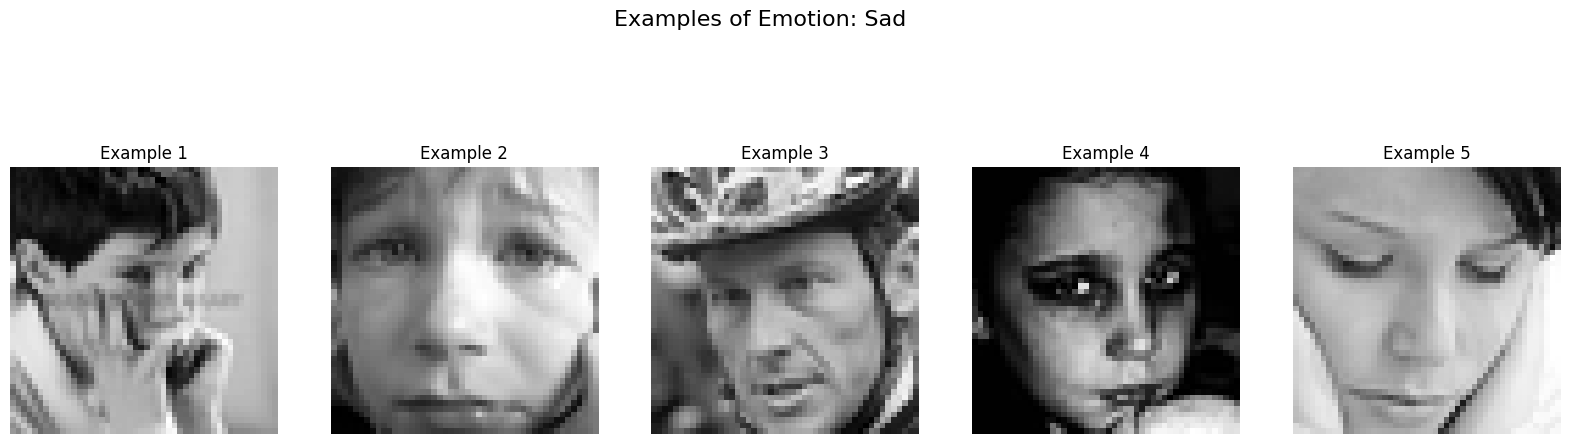

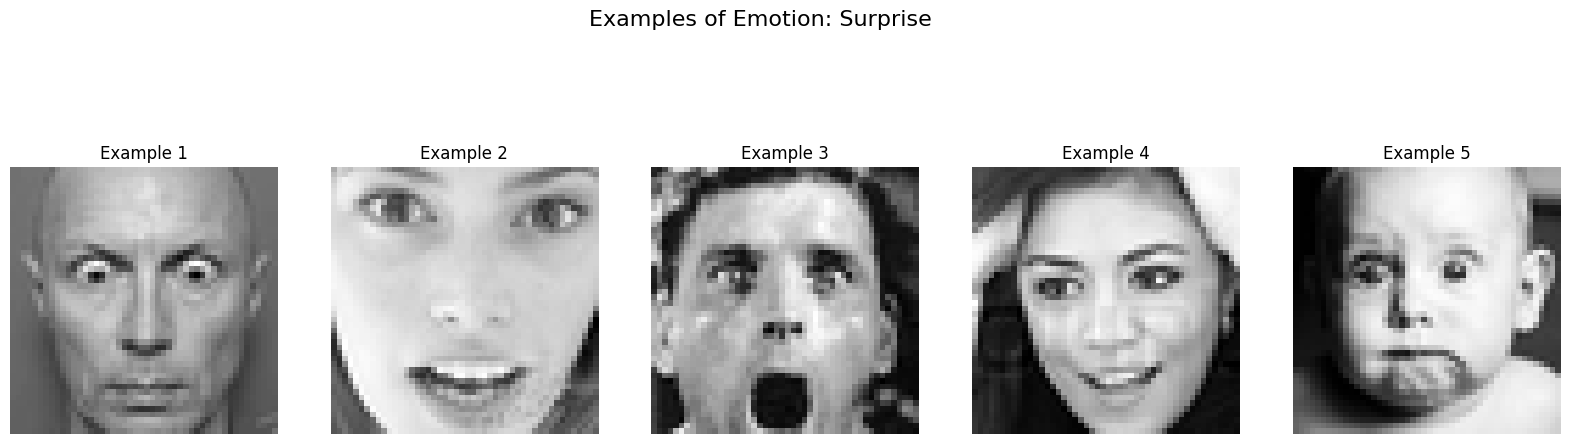

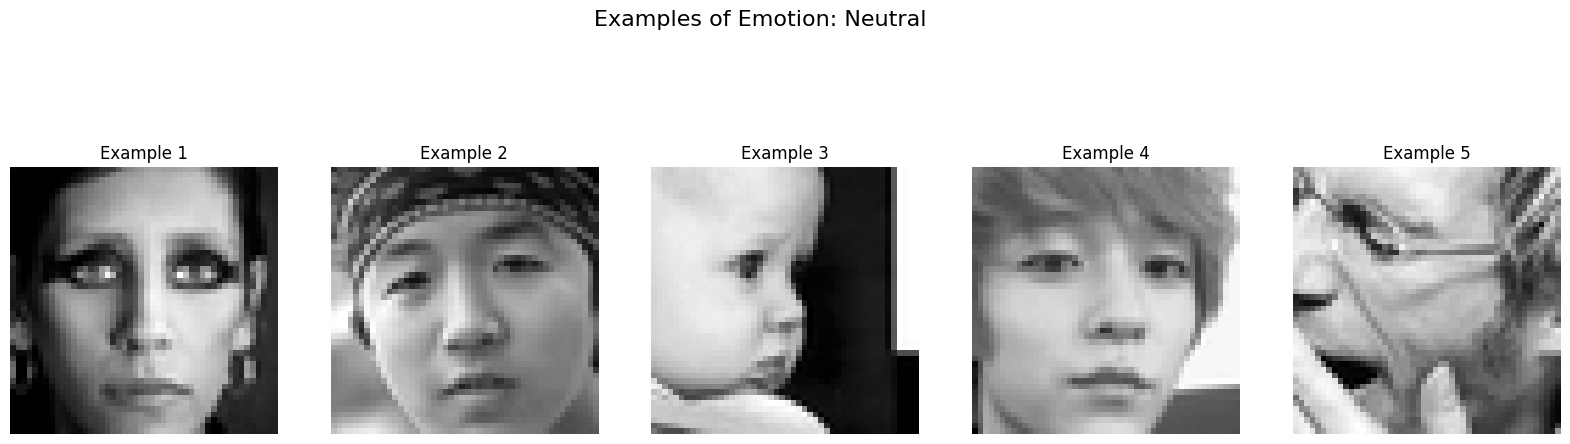

In [17]:
# Plot examples of each emotion
for label in range(7):
    plot_emotion_examples(label)

In [26]:
# Plot comparison of distributions
def plot_distribution_comparison(true_labels, pred_labels, title1='', title2=''):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    true_counts = pd.Series(true_labels.argmax(axis=1)).value_counts().sort_index()
    pred_counts = pd.Series(pred_labels.argmax(axis=1)).value_counts().sort_index()
    
    axs[0].bar(x, true_counts, color='orange', label='True Distribution')
    axs[0].set_title(title1)
    axs[0].legend()
    
    axs[1].bar(x, pred_counts, label='Predicted Distribution')
    axs[1].set_title(title2)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()


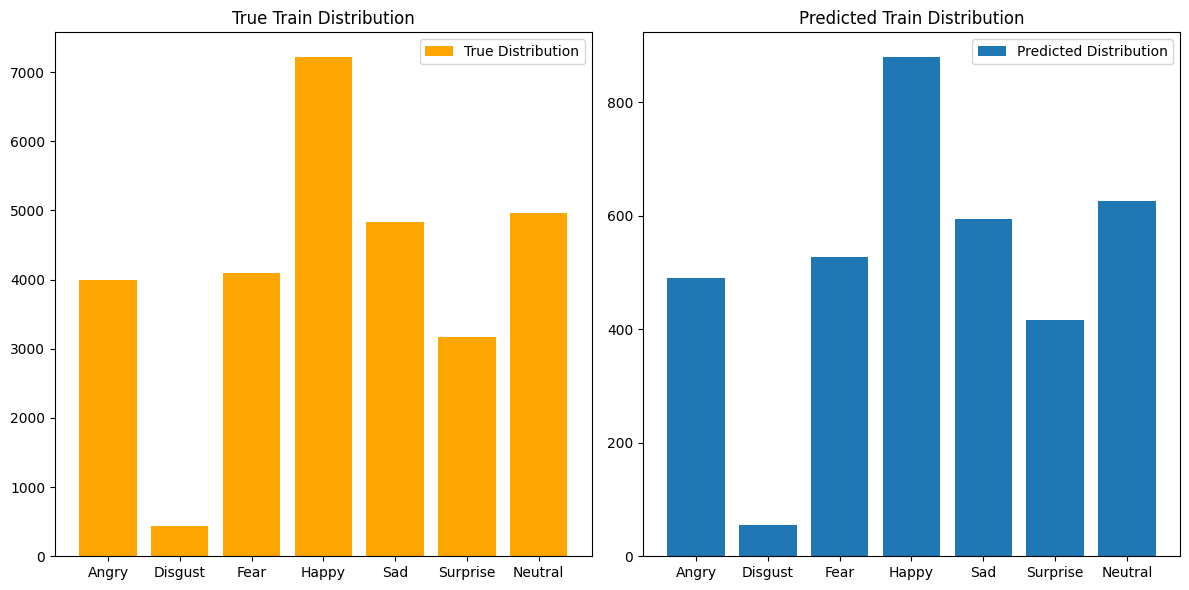

In [28]:
# Plot comparison of true and predicted distributions for train and validation sets
plot_distribution_comparison(train_labels, val_labels, title1='True Train Distribution', title2='Predicted Train Distribution')
# plot_distribution_comparison(test_labels, pred_test_labels, title1='True Test Distribution', title2='Predicted Test Distribution')

<Figure size 800x800 with 0 Axes>

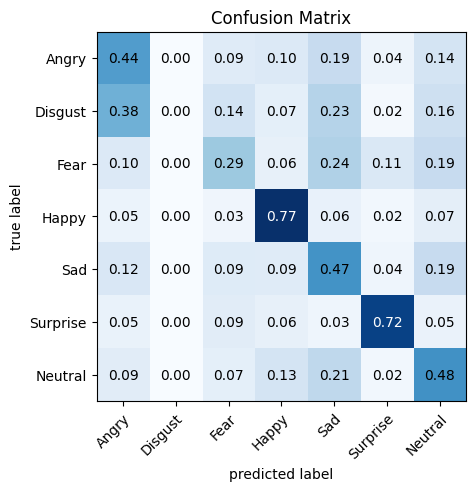

In [20]:
# Plot confusion matrix
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))
plt.figure(figsize=(8, 8))
plot_confusion_matrix(conf_mat=conf_mat, show_normed=True, show_absolute=False, class_names=emotions.values())
plt.title('Confusion Matrix')
plt.show()